<a href="https://colab.research.google.com/github/RP272/Hands-On-ML/blob/main/Classification_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load MNIST

In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784", version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X, y = mnist["data"], mnist["target"]
print(X.shape)
print(y.shape)
X = X.to_numpy()
y = y.to_numpy()

(70000, 784)
(70000,)


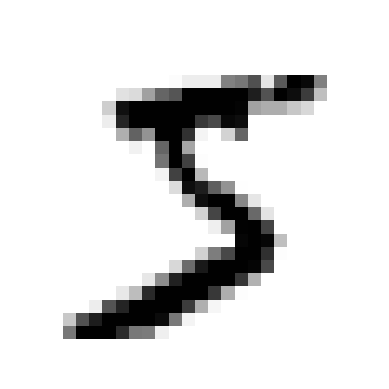

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()


# Split dataset into train and test sets

In [4]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Binary classifier. Number 5 detector. SGD classifier

In [5]:
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

In [6]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

sgd_clf.predict([some_digit])

array([ True])

## Binary classifier metrics: precision, recall, ROC, AUC

In [7]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
  plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
  plt.plot(thresholds, recalls[:-1], "g-", label="Recall")

def plot_precision_vs_recall(precisions, recalls):
  plt.plot(recalls, precisions, "b--")

def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0, 1], [0, 1], 'k--')


from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_curve

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

### Precision and recall vs threshold

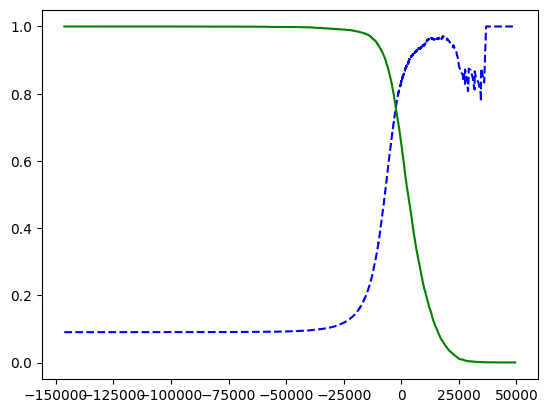

In [8]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

### Precision vs recall


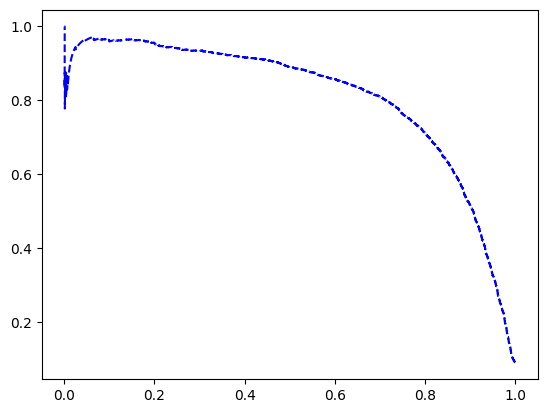

In [9]:
plot_precision_vs_recall(precisions, recalls)
plt.show()

### ROC (receiver operating characteristic) curve

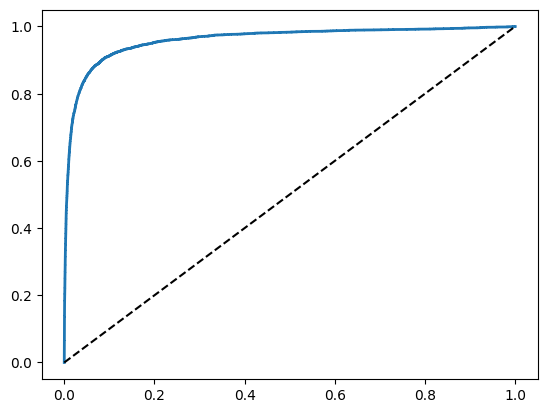

In [10]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)
plot_roc_curve(fpr, tpr)
plt.show()

### ROC AUC (area under curve) metric

In [11]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

np.float64(0.9604938554008616)

# Number 5 detector with RandomForestClassifier

In [12]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")
y_probas_forest


array([[0.11, 0.89],
       [0.99, 0.01],
       [0.96, 0.04],
       ...,
       [0.02, 0.98],
       [0.92, 0.08],
       [0.94, 0.06]])

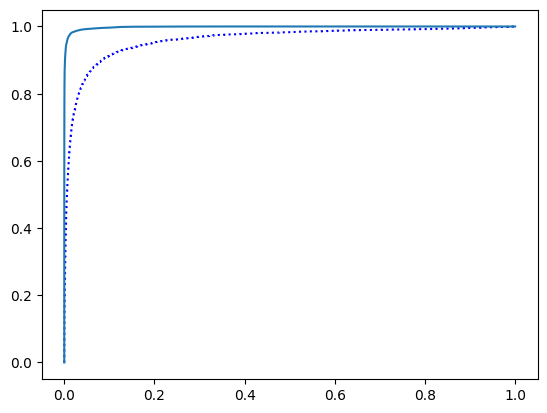

np.float64(0.9983436731328145)

In [13]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

plt.plot(fpr, tpr, "b:", label="SGD")
plt.plot(fpr_forest, tpr_forest, label="Random Forest")
plt.show()

roc_auc_score(y_train_5, y_scores_forest)

In [14]:
from sklearn.metrics import precision_score, recall_score

y_forest_predict = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
print("Precision: ", precision_score(y_train_5, y_forest_predict))
print("Recall: ", recall_score(y_train_5, y_forest_predict))


Precision:  0.9905083315756169
Recall:  0.8662608374838591


# Multiclass classifier
Below section describes the implementation of multiclass classifier, that will classify all ten digits instead of just 5, non-5 classes. *KNeighborsClassifier* will be used in order to try and achieve accuracy above 97%.

In [17]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

knn_clf = KNeighborsClassifier()
knn_scores = cross_val_score(knn_clf, X_train, y_train, cv=3, scoring="accuracy")
print(knn_scores)



[0.9676  0.9671  0.96755]


Without fine-tuning the *KNeighborsClassifier* achieved 96% average accuracy for cross-validation.

In [25]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'weights': ["uniform", "distance"], 'n_neighbors': [3, 5, 7, 11]}
]

grid_search = GridSearchCV(knn_clf, param_grid, cv=3, scoring="accuracy")
grid_search.fit(X_train, y_train)

cvres = grid_search.cv_results_
print(grid_search.best_params_)

for accuracy, params in zip(cvres["mean_test_score"], cvres["params"]):
  print(accuracy, params)

{'n_neighbors': 3, 'weights': 'distance'}
0.9681833333333333 {'n_neighbors': 3, 'weights': 'uniform'}
0.9693333333333333 {'n_neighbors': 3, 'weights': 'distance'}
0.9674166666666667 {'n_neighbors': 5, 'weights': 'uniform'}
0.9686 {'n_neighbors': 5, 'weights': 'distance'}
0.9652 {'n_neighbors': 7, 'weights': 'uniform'}
0.9666666666666667 {'n_neighbors': 7, 'weights': 'distance'}
0.96205 {'n_neighbors': 11, 'weights': 'uniform'}
0.9632166666666667 {'n_neighbors': 11, 'weights': 'distance'}


Without feature-scaling, fine-tuning best run achieved 96.93 % accuracy.

In [27]:
from sklearn.preprocessing import StandardScaler
import numpy as np

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
grid_search = GridSearchCV(knn_clf, param_grid, cv=3, scoring="accuracy")
grid_search.fit(X_train_scaled, y_train)

cvres = grid_search.cv_results_
print(grid_search.best_params_)

for accuracy, params in zip(cvres["mean_test_score"], cvres["params"]):
  print(accuracy, params)


{'n_neighbors': 5, 'weights': 'distance'}
0.9396666666666667 {'n_neighbors': 3, 'weights': 'uniform'}
0.9415666666666667 {'n_neighbors': 3, 'weights': 'distance'}
0.9403666666666667 {'n_neighbors': 5, 'weights': 'uniform'}
0.9420999999999999 {'n_neighbors': 5, 'weights': 'distance'}
0.9384333333333332 {'n_neighbors': 7, 'weights': 'uniform'}
0.9402666666666667 {'n_neighbors': 7, 'weights': 'distance'}
0.9344666666666667 {'n_neighbors': 11, 'weights': 'uniform'}
0.9359166666666666 {'n_neighbors': 11, 'weights': 'distance'}


Feature scaling decreased the accuracy this time to 94% accuracy for the best run.

Let's test how the best classifier will handle the test set.


In [30]:
from sklearn.metrics import accuracy_score

knn_clf = KNeighborsClassifier(
    weights="distance",
    n_neighbors=3
)

knn_clf.fit(X_train, y_train)

test_set_predictions = knn_clf.predict(X_test)
print(accuracy_score(y_test, test_set_predictions))


0.9717


Hooray! Got 97.17% on test set